In [1]:
!pip install monai


     |████████████████████████████████| 358kB 6.1MB/s 


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/MyDrive/monai'

/content/gdrive/MyDrive/monai


In [4]:
!wget -q https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz

In [5]:
# unzip the '.tar.gz' file to the current directory
import tarfile
datafile = tarfile.open("MedNIST.tar.gz")
datafile.extractall()
datafile.close()

In [6]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

     |████████████████████████████████| 430kB 5.7MB/s 
     |████████████████████████████████| 81kB 6.6MB/s 
     |████████████████████████████████| 50.1MB 82kB/s 
     |████████████████████████████████| 14.4MB 30.1MB/s 
     |████████████████████████████████| 14.0MB 177kB/s 
     |████████████████████████████████| 68.0MB 58kB/s 
     |████████████████████████████████| 10.3MB 34.4MB/s 
     |████████████████████████████████| 36.3MB 125kB/s 


In [9]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

#from monai.config import print_config
from monai.transforms import \
    Compose, LoadImage, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.networks.nets import densenet121
from monai.metrics import compute_roc_auc

In [10]:
ls

MedNIST/  MedNIST.tar.gz


In [11]:
data_dir = './MedNIST/'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


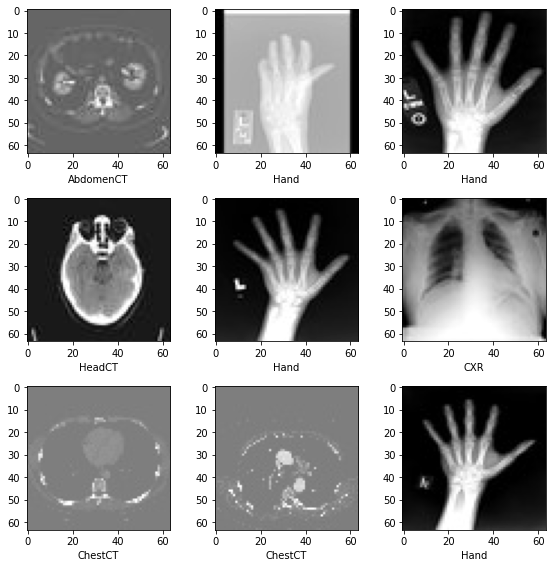

In [12]:
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [13]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 47156 Validation count = 5913 Test count = 5885


In [14]:
train_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [15]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [18]:
device = torch.device("cuda:0")
model = densenet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
)#.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 1
val_interval = 1

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, softmax=True)
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/1


This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [ ]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))